# Tutorial 05 - Acoustic Wave Propagation

## Acoustic Forward Simulation

In this notebook we will go through a simple example of setting up a purely acoustic forward simulation in PestoSeis for a 2D portion of the "SEG/EAGE Salt and Overthrust Model" [(Aminzadeh et al., 1997)](#References).

## Preamble

In [1]:
import pestoseis
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import RectBivariateSpline

## Model Interpolation

First, we will import the HDF5 (`.h5`) model which contains the following keys:
- `vp`: P-wave velocity model (in units of \[m/s\])
- `ijsrcs`: Indices of the source positions
- `ijrecs`: Indices of the receiver positions

In [2]:
data_path = "model.h5"
with h5py.File(str(data_path), "r") as f:
    vp = np.array(f["vp"])
    sources = np.array(f["ijsrcs"], dtype=int)
    receivers = np.array(f["ijrecs"], dtype=int)

We can plot the velocity model to verify that the data has been imported correctly.

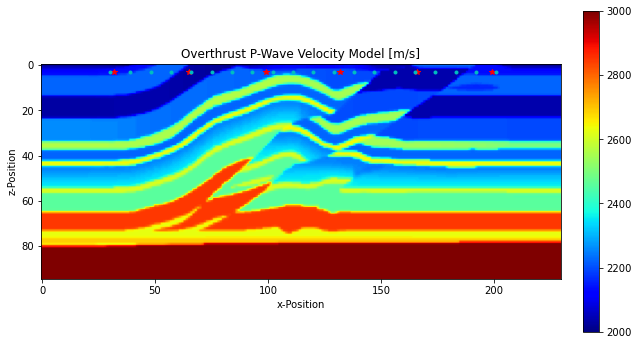

In [3]:
plt.figure(figsize=[10, 16])
im = plt.imshow(vp.T, origin="upper", cmap="jet")
plt.plot(sources[0, :], sources[1, :], "*r")
plt.plot(receivers[0, :], receivers[1, :], ".c")
plt.xlabel("x-Position")
plt.ylabel("z-Position")
plt.title("Overthrust P-Wave Velocity Model [m/s]")
plt.colorbar(im, fraction=0.046*(10/16), pad=0.04)
plt.show()

Notice that the P-wave velocity model is currently fairly coarse (ie. there are relatively few samples in the x- and z-directions).  This discretisation is currently too coarse for the desired source frequency we want to use for this example (50 Hz), so we need to interpolate this coarser model onto a finer grid.  A fairly simple way of accomplishing this is to use the `RectBivariateSpline` tool from the `scipy` package.

We can set a desired scaling factor (see `scale`) which will scale the number of samples in each of the x- and z-directions.

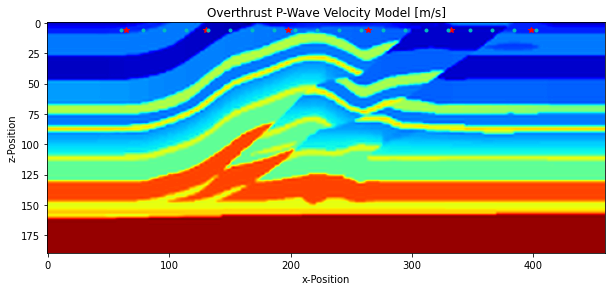

In [4]:
scale = 2

interp_fun = RectBivariateSpline(np.linspace(0, vp.shape[0], vp.shape[0]), np.linspace(0, vp.shape[1], vp.shape[1]), vp)
vp = interp_fun(np.linspace(0, vp.shape[0], vp.shape[0]*scale), np.linspace(0, vp.shape[1], vp.shape[1]*scale))

sources *= scale
receivers *= scale

plt.figure(figsize=[10, 16])
plt.imshow(vp.T, origin="upper", cmap="jet")
plt.plot(sources[0, :], sources[1, :], "*r")
plt.plot(receivers[0, :], receivers[1, :], ".c")
plt.xlabel("x-Position")
plt.ylabel("z-Position")
plt.title("Overthrust P-Wave Velocity Model [m/s]")
plt.show()

## Simulation Setup

Next, we can set up the simulation itself.  For this example, we will be explicitly defining the following:
- Time step
- Number of time steps
- Source time function characteristics (Ricker wavelet)
- Free surface boundary conditions at the surface of the domain
- PMLs on all other sides

In [5]:
# Temporal discretization
nt = 2000
dt = 0.0005
t = np.arange(0.0, nt*dt, dt)

# Spatial discretization
nx = vp.shape[0]
nz = vp.shape[1]
dh = 10 / scale

# Sources
t0 = 0.03
f0 = 25.0
ijsrc = sources[:, 2]

# Source time function
sourcetf = pestoseis.seismicwaves2d.sourcetimefuncs.rickersource( t, t0, f0 )

# Receivers
nrec = receivers.shape[1]
recpos = receivers.T * dh

print(("Receiver positions:\n{}".format(recpos)))

# Initiallize input parameter dictionary
inpar = {}
inpar["ntimesteps"] = nt
inpar["nx"] = nx
inpar["nz"] = nz
inpar["dt"] = dt
inpar["dh"] = dh
inpar["savesnapshot"] = True
inpar["snapevery"] = 50
inpar["freesurface"] = True
inpar["boundcond"] = "PML" #"GaussTap", "PML", "GaussTap","ReflBou"

Receiver positions:
[[ 300.   30.]
 [ 390.   30.]
 [ 480.   30.]
 [ 570.   30.]
 [ 660.   30.]
 [ 750.   30.]
 [ 840.   30.]
 [ 930.   30.]
 [1020.   30.]
 [1110.   30.]
 [1200.   30.]
 [1290.   30.]
 [1380.   30.]
 [1470.   30.]
 [1560.   30.]
 [1650.   30.]
 [1740.   30.]
 [1830.   30.]
 [1920.   30.]
 [2010.   30.]]


## Running the Simulation

Now that we have set up the forward simulation, we can run this using `solveacoustic2D` in `pestoseis`.

In [6]:
seism, psave = pestoseis.seismicwaves2d.acousticwaveprop2D.solveacoustic2D(inpar, ijsrc, vp, sourcetf, f0, recpos)

Starting ACOUSTIC solver with CPML boundary condition.
 Stability criterion, CFL number: 0.42734622684758544
 * Free surface at the top *
 Size of PML layers in grid points: 21 in x and 21 in z
 Time step dt: 0.0005
 Time step 1900 of 2000 
Saved acoustic simulation and parameters to  acoustic_snapshots.h5


## Plotting the Results

In [7]:
h5_data = "acoustic_snapshots.h5"
anim = pestoseis.seismicwaves2d.animatewaves.animateacousticwaves(h5_data, clipamplitude=0.1)
plt.close(anim._fig)

from IPython.display import HTML
HTML(anim.to_html5_video())

## References
> Aminzadeh, F., Brac, J., Kunz, T., Society of Exploration Geophysicists, & European Association of Geophysicists and Engineers. (1997). 3-D salt and overthrust models. Society of Exploration Geophysicists. https://wiki.seg.org/wiki/SEG/EAGE_Salt_and_Overthrust_Models